In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy
import statsmodels.api as sm
import pystan
pd.options.display.precision = 2

%matplotlib inline
custom_style = {'axes.labelcolor': 'white',
                'xtick.color': 'white',
                'ytick.color': 'white'}
sns.set_style("darkgrid", rc=custom_style)
sns.set_context('notebook')
plt.style.use('dark_background')
plt.figure(figsize=(15,10))
sns.set_palette("pastel")

<Figure size 1080x720 with 0 Axes>

In [55]:
df = pd.read_csv('./data9.csv')
df['Intercept'] = 1
df['N-y'] = 8 - df['y']

In [56]:
glm = sm.GLM(endog=df['y'], exog=df[['Intercept', 'x']], family=sm.families.Poisson())

In [57]:
fit = glm.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   20
Model:                            GLM   Df Residuals:                       18
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -45.018
Date:                Sat, 29 Sep 2018   Deviance:                       14.171
Time:                        17:17:48   Pearson chi2:                     13.6
No. Iterations:                     4   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5661      0.360      4.351      0.000       0.861       2.272
x              0.0833      0.068      1.219      0.223      -0.051       0.217
==============================================================================
"""

In [58]:
fit.params

Intercept    1.57
x            0.08
dtype: float64

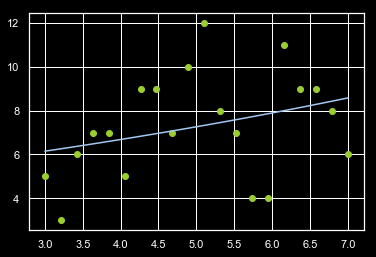

In [60]:
x = np.linspace(3,7,100)
y = np.exp(fit.params[0] + fit.params[1] * x)
plt.scatter(df['x'], df['y'], color='yellowgreen')
plt.plot(x, y)

In [61]:
stan_model = """
    data{
        int<lower=1> N;
        real X[N];
        int<lower=0> y[N];
        real xmean;
    }
    
    parameters {
        real beta1;
        real beta2;
    }
    
    model{
        beta1 ~ normal(0, 100);
        beta2 ~ normal(0, 100);
        for(n in 1:N){
            y[n] ~ poisson_log(beta1 + beta2 * (X[n] - xmean));
        }
    }
"""

In [62]:
sm = pystan.StanModel(model_code = stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_57939288832ce161c5bdb5fcdca1700f NOW.


In [63]:
stan_data = {"N": len(df), "X":df["x"], "y": df["y"], "xmean": df["x"].mean()}
fit = sm.sampling(data=stan_data, iter=1600, warmup=100, chains=1, seed=123)

/Users/yugi/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [64]:
fit

Inference for Stan model: anon_model_57939288832ce161c5bdb5fcdca1700f.
1 chains, each with iter=1600; warmup=100; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=1500.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta1   1.97  2.7e-3   0.08   1.81   1.92   1.97   2.03   2.13    917    1.0
beta2   0.09  1.8e-3   0.07  -0.05   0.04   0.09   0.13   0.22   1500    1.0
lp__  143.95    0.04   1.01 141.17 143.58 144.25 144.67 144.94    756    1.0

Samples were drawn using NUTS at Sat Sep 29 17:19:21 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

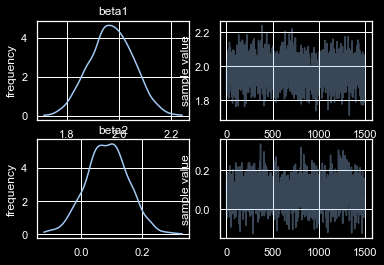

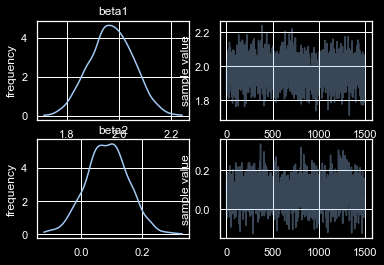

In [65]:
fit.plot()

In [50]:
df_sample = pd.DataFrame()
df_sample['beta1'] = fit.extract()['beta1']
df_sample['beta2'] = fit.extract()['beta2']

Text(0,0.5,'y predict')

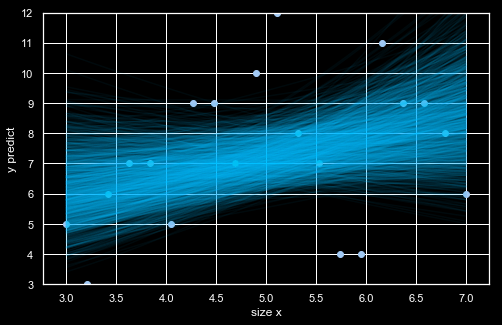

In [77]:
x = np.linspace(3,7,100)
x_mean = df['x'].mean()
plt.figure(figsize=(8,5))
for i in range(len(df_sample)):
    y_pred = np.exp(df_sample.loc[i, 'beta1'] + df_sample.loc[i, 'beta2'] * (x - x_mean))
    plt.plot(x, y_pred, color='deepskyblue', alpha = 0.05)
plt.scatter(df['x'], df['y'])
plt.ylim(3, 12)
plt.xlabel('size x')
plt.ylabel('y predict')

Text(0,0.5,'beta2')

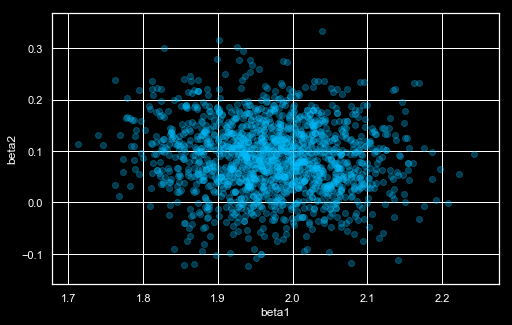

In [79]:
plt.figure(figsize=(8,5))
plt.scatter(df_sample['beta1'], df_sample['beta2'], alpha=0.3, color='deepskyblue')
plt.xlabel('beta1')
plt.ylabel('beta2')

In [91]:
stan_model2 = """
    data{
        int<lower=1> N;
        real X[N];
        int<lower=0> y[N];
        real xmean;
    }
    
    parameters {
        real beta1;
        real beta2;
    }
    
    transformed parameters{
        real lambda[N];
        for(n in 1:N){
            lambda[n] = exp(beta1 + beta2 * (X[n] - xmean));
        }
    }
    
    model{
        beta1 ~ normal(0, 100);
        beta2 ~ normal(0, 100);
        for(n in 1:N){
            y[n] ~ poisson(lambda[n]);
        }
    }
"""

In [92]:
sm2 = pystan.StanModel(model_code = stan_model2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_22aab264bd33be020be1aeab3815ed5c NOW.


In [93]:
stan_data2 = {"N": len(df), "X":df["x"], "y": df["y"], "xmean": df["x"].mean()}
fit2 = sm2.sampling(data=stan_data2, iter=1600, warmup=100, chains=1, seed=123)

/Users/yugi/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [94]:
fit2

Inference for Stan model: anon_model_22aab264bd33be020be1aeab3815ed5c.
1 chains, each with iter=1600; warmup=100; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=1500.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta1        1.97  2.7e-3   0.08   1.81   1.92   1.97   2.03   2.13    917    1.0
beta2        0.09  1.8e-3   0.07  -0.05   0.04   0.09   0.13   0.22   1500    1.0
lambda[0]    6.14    0.03   1.04   4.24    5.4   6.05   6.82   8.36   1209    1.0
lambda[1]    6.24    0.03   0.98   4.44   5.54   6.15   6.88   8.29   1182    1.0
lambda[2]    6.34    0.03   0.92   4.63    5.7   6.27   6.95   8.26   1151    1.0
lambda[3]    6.44    0.03   0.85   4.84   5.86   6.38    7.0   8.23   1116    1.0
lambda[4]    6.55    0.02    0.8   5.05    6.0   6.51   7.07   8.21   1077    1.0
lambda[5]    6.66    0.02   0.74   5.28   6.15   6.63   7.16   8.18   1036    1.0
lambda[6]    6.78    0.02   0.69   5.48    6.3   6.75   7.23   8.17    996

In [95]:
df_sample2 = pd.DataFrame()
df_sample2['beta1'] = fit2.extract()['beta1']
df_sample2['beta2'] = fit2.extract()['beta2']

Text(0,0.5,'y predict')

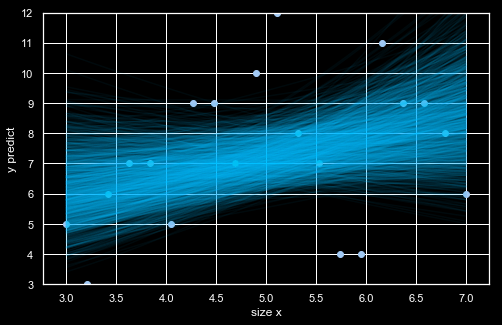

In [96]:
x = np.linspace(3,7,100)
x_mean = df['x'].mean()
plt.figure(figsize=(8,5))
for i in range(len(df_sample)):
    y_pred = np.exp(df_sample2.loc[i, 'beta1'] + df_sample2.loc[i, 'beta2'] * (x - x_mean))
    plt.plot(x, y_pred, color='deepskyblue', alpha = 0.05)
plt.scatter(df['x'], df['y'])
plt.ylim(3, 12)
plt.xlabel('size x')
plt.ylabel('y predict')

Text(0,0.5,'beta2')

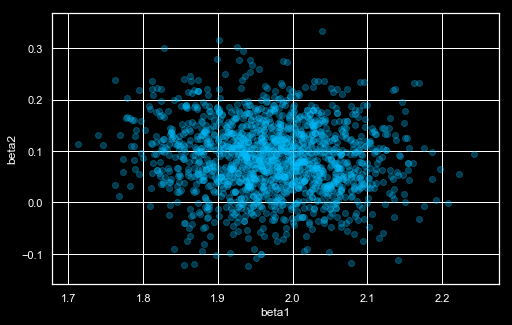

In [97]:
plt.figure(figsize=(8,5))
plt.scatter(df_sample2['beta1'], df_sample2['beta2'], alpha=0.3, color='deepskyblue')
plt.xlabel('beta1')
plt.ylabel('beta2')